In [55]:
import pandas as pd
import glob

csv_files = glob.glob("../results/independent/*.csv")

df_list = []

for file in csv_files:
    region_name = file.split("\\")[-1].split(".csv")[0]
    
    df = pd.read_csv(file)
    df["Region"] = region_name
    df_list.append(df)

all_df = pd.concat(df_list, ignore_index=True)

In [ ]:
import matplotlib.pyplot as plt

regions = all_df["Region"].unique()
num_regions = len(regions)

cols = 4
rows = 4

fig, axes = plt.subplots(rows, cols, figsize=(20, 12), sharex=True, sharey=True)

for idx, region in enumerate(regions):
    r = idx // cols
    c = idx % cols
    ax = axes[r, c]
    
    region_df = all_df[all_df["Region"] == region]
    ax.plot(region_df["epoch"], region_df["recall"], marker='x')
    ax.set_title(region)
    ax.grid(True)

fig.suptitle("Recall over Epochs by Region", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../plots/independent/recall.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

data_dir = "../results/pairwise-transfer/"

csv_files = os.listdir(data_dir)

for file in csv_files:
    df_transfer = pd.read_csv(data_dir + file)
    df_original = pd.read_csv("../results/intra-region/" + file)

    best_row_original = df_original.loc[df_original['iou'].idxmax()]
    best_row_original = best_row_original.to_frame().T

    region = file.split(".csv")[0]

    best_row_original["region"] = region
    best_row_original["highlight"] = True

    df_transfer["highlight"] = False

    combined_df = pd.concat([best_row_original, df_transfer], ignore_index=True)

    properties = ["precision","recall","f1","iou","oa"]
    names = ["Precision", "Recall", "F1", "IoU", "Overall Accuracy"]

    fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(12,30))
    axes = axes.flatten()

    for i, prop in enumerate(properties):
        ax = axes[i]
        bars = ax.bar(
            combined_df["region"],
            combined_df[prop],
            color=["red" if highlight else "blue" for highlight in combined_df["highlight"]]
        )
        ax.set_title(f'{names[properties.index(prop)]} Comparison Across Regions')
        ax.set_ylabel(prop.upper())
        ax.set_xticks(range(len(combined_df["region"])))
        ax.set_xticklabels(combined_df["region"], rotation=90)
        ax.set_ylim(0, combined_df[prop].max() * 1.1)

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}", ha="center", va="bottom")
        
    fig.suptitle(f'{region} Comparison of Metrics Across Models Trained on Different Regions (Pairwise Transfer)', fontsize=15)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig("../plots/pairwise-transfer/" + region + ".png", dpi=300, bbox_inches="tight")
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

df_list = []

data_dir = "../results/intra-region/"

for file in os.listdir(data_dir):
    df = pd.read_csv(os.path.join(data_dir, file))
    df["Region"] = file.split(".csv")[0]
    df_list.append(df)

all_df = pd.concat(df_list, ignore_index=True)

all_df = all_df[all_df["val_loss"] != 0.0]

properties = ["precision", "recall", "f1", "iou", "oa"]
names = ["Precision", "Recall", "F1", "IoU", "Overall Accuracy"]

def std_error(x):
    return x.std(ddof=1) / np.sqrt(len(x))

summary_df = all_df.groupby("Region")[properties].agg(["mean", std_error])
summary_df.columns = ["_".join(col).strip() for col in summary_df.columns.values]
summary_df = summary_df.reset_index()

fig, axes = plt.subplots(5, 1, figsize=(12, 30), sharey=False)

for idx, metric in enumerate(properties):
    mean_col = f"{metric}_mean"
    se_col = f"{metric}_std_error"
    ax = axes[idx]

    ax.bar(
        summary_df["Region"],
        summary_df[mean_col],
        yerr=summary_df[se_col] * 2,
        capsize=5,
        color="skyblue",
        edgecolor="black"
    )
    ax.set_title(names[idx])
    ax.set_xticks(range(len(summary_df["Region"])))
    ax.set_xticklabels(summary_df["Region"], rotation=90)
    ax.set_ylim(0, 1)

axes[0].set_ylabel("Score")

fig.suptitle(f'Average of Metrics Across Regions', fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("../plots/intra-region/averages.png", dpi=300, bbox_inches="tight")
plt.show()

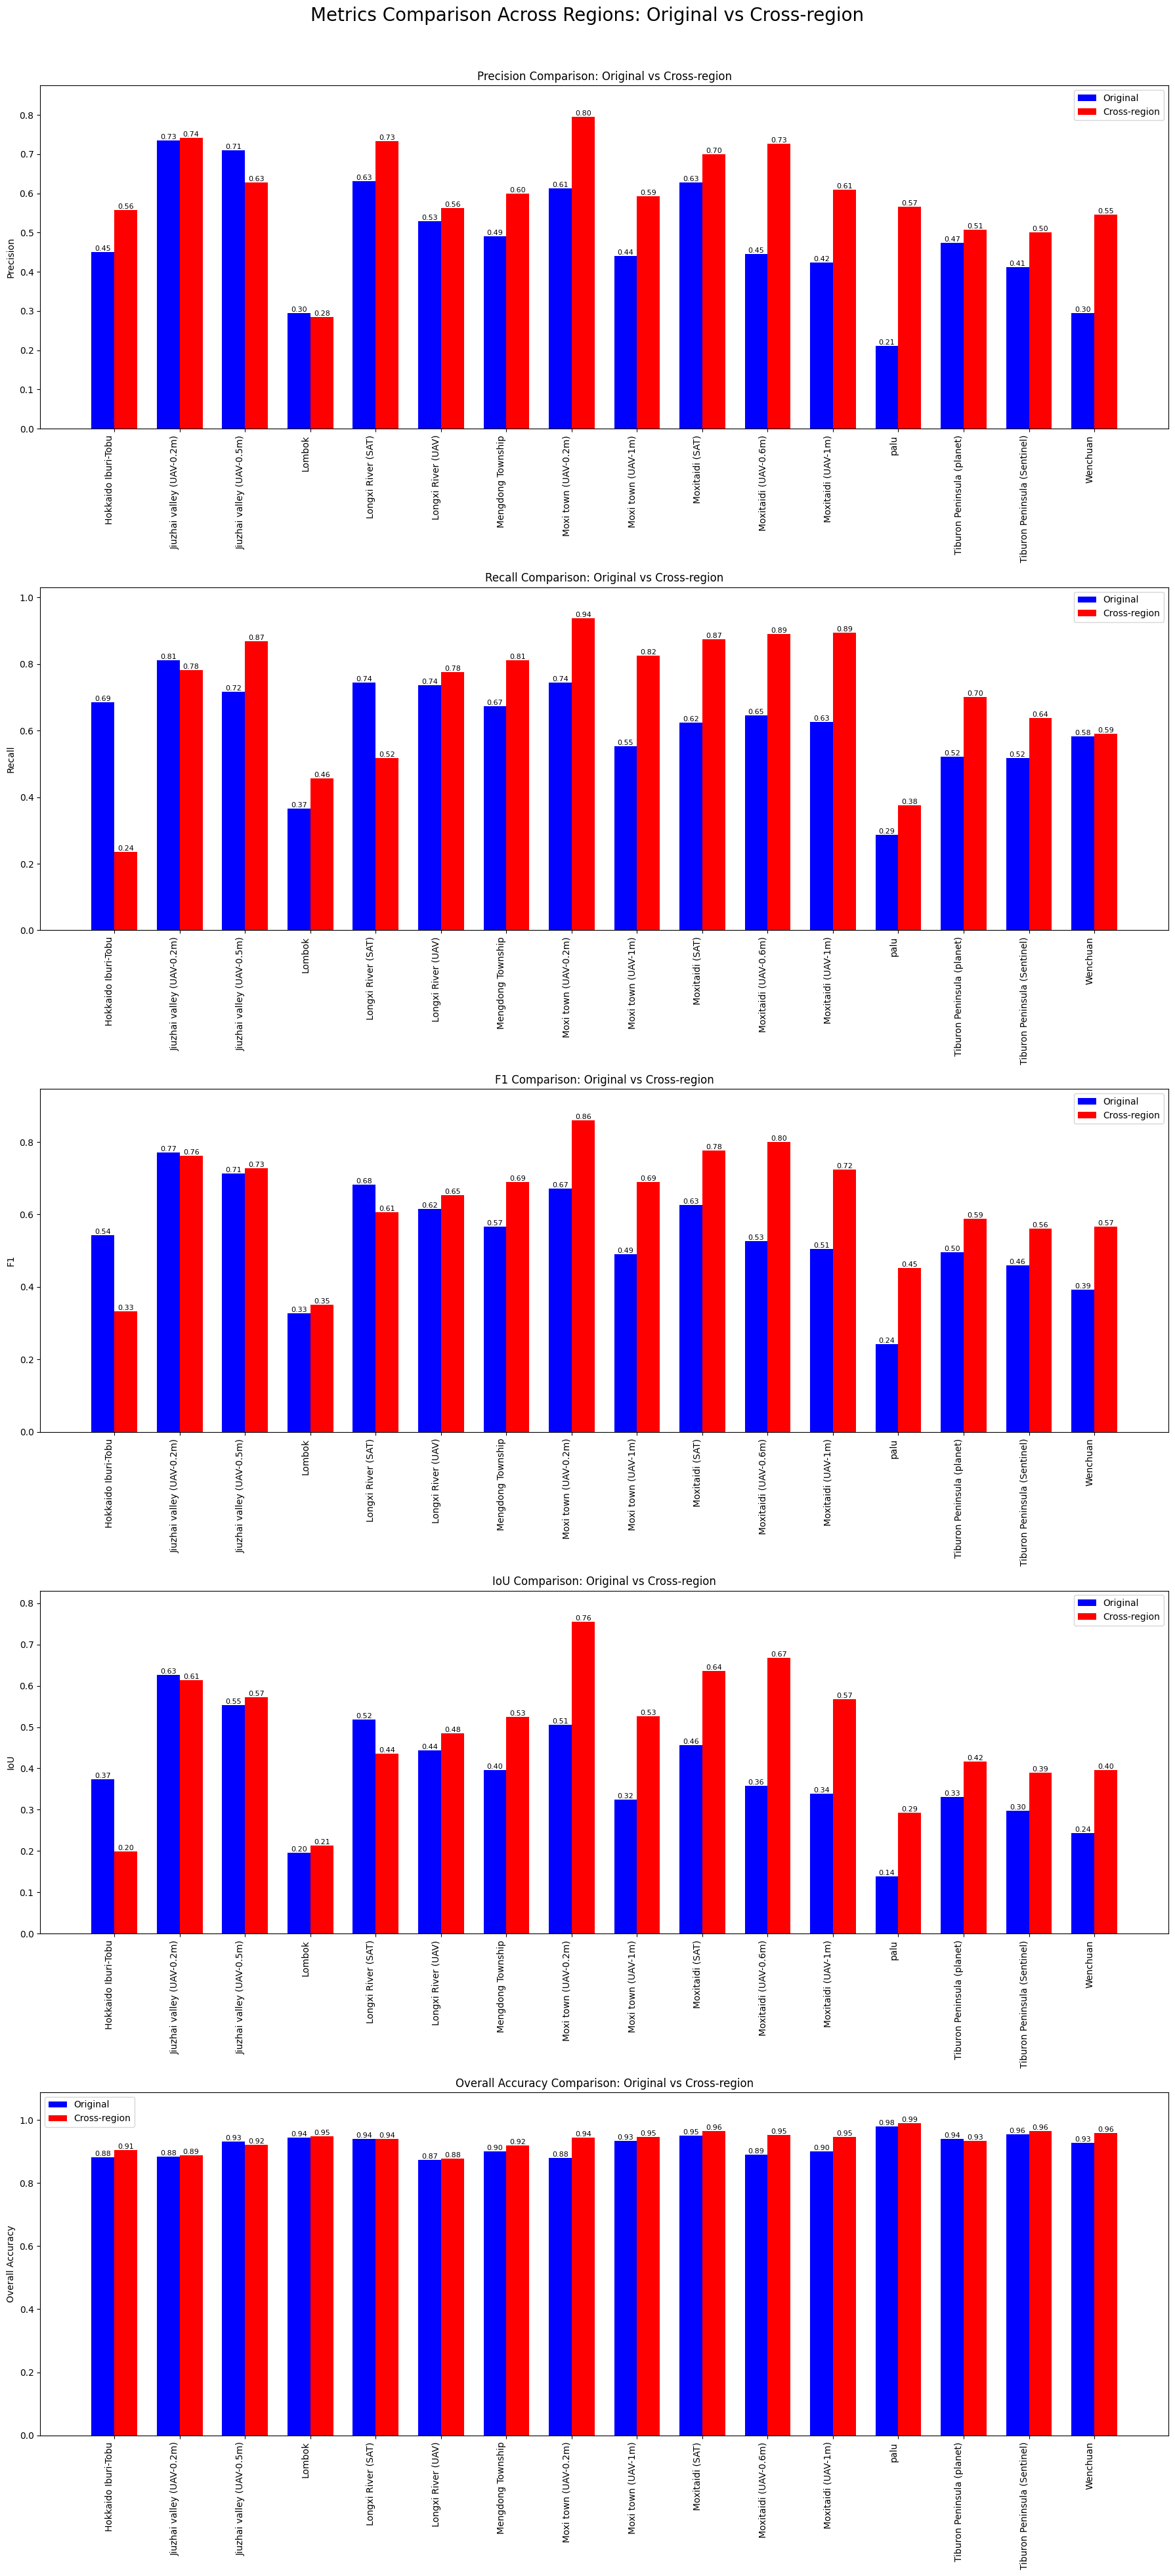

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import os

cross_region_csv = "../results/loo-cross-region/metrics.csv"
df_transfer = pd.read_csv(cross_region_csv)

intra_region_dir = "../results/intra-region/"

all_data = []

for file in os.listdir(intra_region_dir):
    if file.endswith(".csv"):
        region = file.split(".csv")[0]
        df_original = pd.read_csv(os.path.join(intra_region_dir, file))
        
        best_row = df_original.loc[df_original['iou'].idxmax()]
        
        all_data.append({
            "region": region,
            "source": "Original",
            "precision": best_row["precision"],
            "recall": best_row["recall"],
            "f1": best_row["f1"],
            "iou": best_row["iou"],
            "oa": best_row["oa"]
        })
        
        cross_row = df_transfer[df_transfer["region"] == region]
        if not cross_row.empty:
            cross_row = cross_row.iloc[0]
            all_data.append({
                "region": region,
                "source": "Cross-region",
                "precision": cross_row["precision"],
                "recall": cross_row["recall"],
                "f1": cross_row["f1"],
                "iou": cross_row["iou"],
                "oa": cross_row["oa"]
            })

combined_df = pd.DataFrame(all_data)

metrics = ["precision", "recall", "f1", "iou", "oa"]
metric_names = ["Precision", "Recall", "F1", "IoU", "Overall Accuracy"]

regions_sorted = combined_df["region"].unique()

# Create figure with 5 subplots vertically
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(18, 40))
axes = axes.flatten()

bar_width = 0.35
x = range(len(regions_sorted))

for ax, metric, name in zip(axes, metrics, metric_names):
    original_vals = [combined_df[(combined_df["region"] == r) & (combined_df["source"] == "Original")][metric].values[0] for r in regions_sorted]
    cross_vals = [combined_df[(combined_df["region"] == r) & (combined_df["source"] == "Cross-region")][metric].values[0] for r in regions_sorted]
    
    x_original = [pos - bar_width / 2 for pos in x]
    x_cross = [pos + bar_width / 2 for pos in x]
    
    ax.bar(x_original, original_vals, width=bar_width, label="Original", color="blue")
    ax.bar(x_cross, cross_vals, width=bar_width, label="Cross-region", color="red")
    
    # Annotate bars
    for xi, val in zip(x_original, original_vals):
        ax.text(xi, val, f"{val:.2f}", ha="center", va="bottom", fontsize=8)
    for xi, val in zip(x_cross, cross_vals):
        ax.text(xi, val, f"{val:.2f}", ha="center", va="bottom", fontsize=8)
    
    ax.set_xticks(x)
    ax.set_xticklabels(regions_sorted, rotation=90, ha="right")
    ax.set_ylabel(name)
    ax.set_title(f"{name} Comparison: Original vs Cross-region")
    ax.set_ylim(0, max(original_vals + cross_vals) * 1.1)
    ax.legend()

fig.suptitle("Metrics Comparison Across Regions: Original vs Cross-region", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.savefig("../plots/loo-cross-region/metrics_comparison.png", dpi=300, bbox_inches="tight")

plt.show()